<a href="https://colab.research.google.com/github/AlexeyTri/Seminars_Med/blob/main/Seminar1_1MED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основные понятия и примеры прикладных задач

# Используемые пакеты

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem1/requirements.txt
    !pip install -q -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.special import expit
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold

# Ирисы Фишера
Выборка взята отсюда: https://archive.ics.uci.edu/ml/datasets/iris

## Загрузка выборки

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem1/data/iris.csv',
                      header=None,
                      names=['длина чашелистика', 'ширина чашелистика',
                             'длина лепестка', 'ширина лепестка', 'класс'])
dataset.sample(5, random_state=0)

,длина чашелистика,ширина чашелистика,длина лепестка,ширина лепестка,класс
114,5.8,2.8,5.1,2.4,Iris-virginica
62,6.0,2.2,4.0,1.0,Iris-versicolor
33,5.5,4.2,1.4,0.2,Iris-setosa
107,7.3,2.9,6.3,1.8,Iris-virginica
7,5.0,3.4,1.5,0.2,Iris-setosa


## Начало работы с данными
1. Определить множество объектов:
    * Определить размер выборки
    * Определить признаки, которыми описываются объекты
2. Определить множество ответов
3. Определить тип задачи машинного обучения
6. ...

### Множество объектов
В данной задачи множество объектов описывается $n=4$ признаками:
1. Длина чашелистика
2. Ширина чашелистика
3. Длина лепестка
4. Ширина лепестка

In [ ]:
print('Размер выборки составляет l={} объектов.'.format(len(dataset)))

Размер выборки составляет l=150 объектов.


Все признаки являются вещественными признаками. Формально объекты $\mathbf{X}$ представляються в следующем виде:
$$\mathbf{X} \in \mathbb{R}^{l\times n},$$
где $l$ число объектов, а $n$ число признаков.

Получаем, что $\mathbf{X}$ это некоторая вещественная матрица размера $l\times n$.

### Множество ответов
В данной задаче множество ответов состоит из трех элементов:
1. Iris-virginica
2. Iris-versicolor
3. Iris-setosa

### Задача машинного обучения
В нашем случае, так как мощность множества $|\mathbf{y}|=3 \ll l=150$ получаем задачу классификации на $M=3$ класса.

## Анализ данных
Сначала проэктируем все объекты на двумерные плоскости, для упрощения анализа

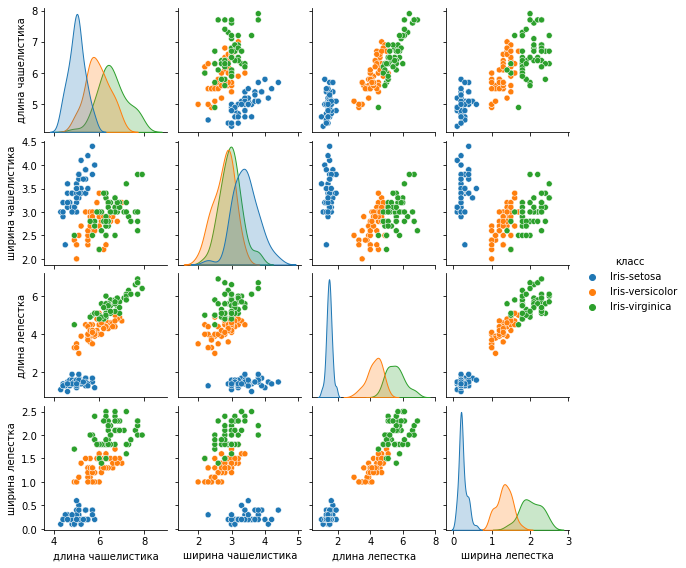

In [ ]:
sns.pairplot(dataset, hue='класс', height=2)
plt.show()

Из рисунка видно, что класс синих точек (Iris-setosa) легко отделяется от двух других цветов. Оранджевые и зеленные точки отделяются не так просто в каждой из проэкций, но все равно можно провести прямую, которая отделит оранджевые точки от зеленых.

## Построение модели
### Преобразование данных
Как было сказано ранее нам требуется решить задачу классификации на 3 класса. Но для наглядноси рассмотрим бинарную классификацию (классификацию на несколько классов рассмотрим в следующей лекции).

Чтобы исходную задачу преобразовать в задачу бинарной классификации уберем из выборки все объекта класса Iris-setosa.

In [ ]:
binary_dataset = dataset.drop(index=dataset.index[dataset['класс'] == 'Iris-setosa'])

Классы закодируем целыми числами $-1$ и $1$.

In [ ]:
binary_dataset.loc[dataset['класс'] == 'Iris-versicolor', dataset.columns == 'класс'] = -1
binary_dataset.loc[dataset['класс'] == 'Iris-virginica', dataset.columns == 'класс'] = 1

Получаем задачу бинарной классификации.

### Модель алгоритмов

Модель алгоритмов $\mathfrak{F}$ в машинном обучении это некоторое множество функций, которые действуют из множества объектов в множество ответов, в нашем случае:
$$\mathfrak{F} = \{f| f: \mathbb{R}^n \to \{-1, 1\}, \text{еще какие-то ограничения}\},$$
обычно $\mathfrak{F}$ это некоторое параметрическое семество функций, тоесть разные функции $f$ отличаются друг от друга только каким-то параметром. Простым примером параметрическим семейством функций для задачи бинарной классификации является семейство линейный классификатор:
$$\mathfrak{F}_{bcl} = \left\{f\bigr(\theta, \mathbf{x}\bigr)=\text{sign}\bigr(\theta^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \theta \in \mathbb{R}^{n} \right\}.$$


### Функция потерь

Машиное обучение это всегда выбор функции из множества $\mathfrak{F}$. Чтобы выбрать функцию, нужен некоторый критерий по которому она выбирается, то есть нужно упоррядочить все функции от худшей к лучшей. Для этого построем функционал $\mathcal{L}$, который каждой функции $f \in \mathfrak{F}$ ставит в соответствии число из $\mathbb{R}_+$. В машинном обучении обычно функционал качества водиться как некоторая ошибка на выборке. В общем виде функционал качества можно представить в следующем виде:
$$\mathcal{L}\bigr(f, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\mathcal{q}\bigr(f, \mathbf{x}_i, y_i\bigr),$$
где $q$ некоторая функция ошибки на некотором объекте $\mathbf{x}$. Функционал качества $\mathcal{L}$ называется эмперическим риском.

### Оптимизационная задача

Далее нужно поставить задачу оптимизации для выбора $f \in \mathfrak{F}$. Здесь все просто, просто минимизируем эмперический риск:
$$\hat{f} = \arg \min_{f \in \mathfrak{F}} \mathcal{L}\bigr(f, \mathbf{X}, \mathbf{y}\bigr).$$

Важно! В результе функция $\hat{f}$ зависит от выборки $\left(\mathbf{X}, \mathbf{y}\right)$, то есть для разных наборов данных оптимальная функция будет различная.

Вернемся к нашей задаче. В нашем случае функционал качества будет иметь следующий вид:
$$\mathcal{L}\bigr(\theta, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr],$$
и оптимизационная задача переписывается в виде:
$$\hat{\theta} = \arg \min_{\theta \in \mathbb{R}^n} \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr].$$

И на самом деле в дальнейшем будем решать иммено такие задачи, на поиск оптимального параметра. Само решение задачи линейной бинарной классификации будет на следующей лекции. Сейчас используемся библиотеками для решения данной задачи. Далее в примере будет найден параметр $\hat{\theta}$ не как решение непосредственно этой оптимизационной задачи, а немного измененной, но об этом позже в следующей лекции.

### Поиск оптимального вектора параметров
Перейдем к двум матрицам:
1. Матрице объектов $\mathbf{X} \in \mathbb{R}^{l\times (n+1)}$
2. Вектору ответов $\mathbf{y} \in \{-1,1\}^l$

Заметим, что объекты мы погрузили в пространство более большой размерности, добавив еще один признак, который у всех объектов будет равен $1$.

In [ ]:
X = binary_dataset.iloc[:, binary_dataset.columns != 'класс'].values
y = binary_dataset.iloc[:, binary_dataset.columns == 'класс'].values.reshape(-1)
X = np.array(np.hstack([X, np.ones([len(X), 1])]), dtype=np.float64)
y = np.array(y, dtype=np.int64)

In [ ]:
model = LogisticRegression(random_state=0, max_iter=2000)
_ = model.fit(X, y)

Получаем вектор оптимальных параметров $\hat{\theta}$

In [ ]:
model.coef_

array([[-3.94426322e-01, -5.13378130e-01,  2.93108661e+00,
         2.41670685e+00, -5.18829563e-04]])

# Переход от бинарной классификации к многоклассовой
Теперь же остается вопрос: как перейти от задачи бинарной классификации к многоклассовой? В качестве бинарного классификатора рассмотрим все ту же модель алгоритмов:
$$\mathfrak{F}_{bcl} = \left\{f\bigr(\theta, \mathbf{x}\bigr)=\text{sign}\bigr(\theta^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \theta \in \mathbb{R}^{n} \right\}.$$

Но знак позволяет отделить только два знака. Какие же есть решения?

Рассмотрим вариант перехода, который называется Один против всех (One VS All). Для простоты визуализации рассмотрим пример на синтетических данных.

## Генерация синтетической выборки

In [9]:
np.random.seed(0)
l = 100
n = 2
X1 = np.array([[-1,-1]]) + 0.5*np.random.randn(l, n)
X2 = np.array([[1,1]]) + 0.5*np.random.randn(l, n)
X3 = np.array([[-1,1]]) + 0.5*np.random.randn(l, n)

X = np.vstack([X1, X2, X3])
y = np.hstack([[0]*l, [1]*l, [2]*l])

# Добавляем константу
X = np.hstack([X, np.ones([len(X), 1])])

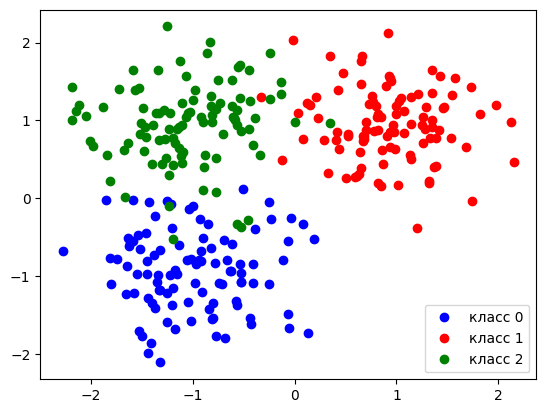

In [4]:
cols = ['blue', 'red', 'green']

# построение точек
for k in np.unique(y):
    plt.plot(X[y==k,0], X[y==k,1], 'o', label='класс {}'.format(k), color=cols[k])

plt.legend(loc='best')
plt.show()

## Один против всех

Данные метод основан на том, что для классификации на $M>2$ классов нужно построить $M$ линейных классификаторов, которые классифицируют $k$-й класс прорив всех остальных классов.

Построим $M=3$ классификатора, которые отделяют каждый класс от двух остальных

In [10]:
models = []
model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==0, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==1, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==2, dtype=np.int64))
models.append(model)

In [11]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b + c)/a, -1
    x2, y2 = -(b + c)/a, 1

    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)

    return x_axis, y_axis

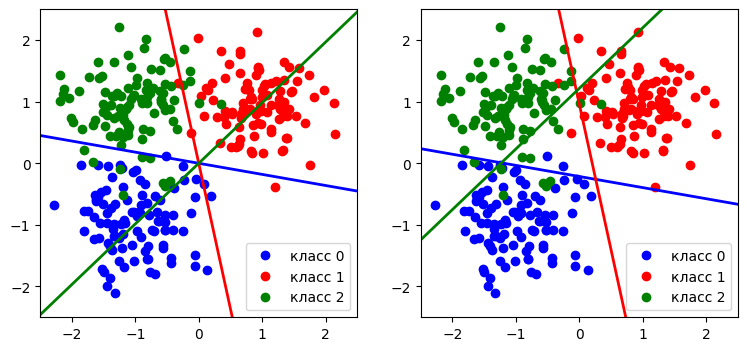

In [12]:
cols = ['blue', 'red', 'green']
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].set_xlim((-2.5, 2.5)), ax[i].set_ylim((-2.5, 2.5))

for k in np.unique(y):
    ax[0].plot(X[y==k,0], X[y==k,1], 'o',
               label='класс {}'.format(k), color=cols[k])
    ax[1].plot(X[y==k,0], X[y==k,1], 'o',
               label='класс {}'.format(k), color=cols[k])

for k in np.unique(y):
    ax[0].plot(*get_line(*models[k].coef_[0][:2]), linewidth=2, color=cols[k])
    ax[1].plot(*get_line(*models[k].coef_[0]), linewidth=2, color=cols[k])

ax[0].legend(loc='best'), ax[1].legend(loc='best')
plt.show()

По данному рисунку возьникает сразу несколько вопросов:
1. Как видно на рисунке в класс зеленых точек попадает много зеленных и много красных точек. Такое случилось, потому, что мы считали просто скалярное произведени, без добавления адитивной константы, которая грубо говоря приближает разделяющую прямую к истинным точкам или отдаляет.
2. Есть точки, которые поадают сразу в несколько областей, что делать с ними? Здесь есть много подходов. Какие есть варианты у вас?

Один из вариантов следующий:
1. Всего плоскость разделена на 6 областей.
2. Считаем в какую область попала точка и получаем нужный класс.

## Методы анализа качества

Самый простой способо это подсчет ошибок, не верных классов:
$$\mathcal{L}\bigr(\theta, \mathbf{X}, \mathbf{y}\bigr) = \sum_{i=1}^l\bigr[f\bigr(\theta, \mathbf{x}_i\bigr) \not= y_i\bigr].$$

Также можно рассмотреть таблицу попарных ошибок:

|               | y = 1 | y = 2 | y = 3 |
| ------------- | ----- | ----- | ----- |
| __f(x) = 1__  |  1-1  |  1-2  |  1-3  |
| __f(x) = 2__  |  2-1  |  2-2  |  2-3  |
| __f(x) = 3__  |  3-1  |  3-2  |  3-3  |

Данная таблица показывает, сколько классификатор сделал ошибок между двумя парами классов. Например:
1. 2-3 это число, которое обозначает, сколько объектов класса $3$ объект отнес к классу $2$
2. 3-1 это число, которое обозначает, сколько объектов класса $1$ объект отнес к классу $3$

Посчитаем данную матрицу для синтетической выборки.

In [ ]:
scores = np.zeros([3,3])
for k in range(3):
    pred = np.argmax(np.vstack([models[i].predict_proba(X[y==k])[:, 1] for i in range(3)]).T, axis=1)
    for i in range(3):
        scores[i, k] = sum(pred == i)


In [ ]:
print(scores)

[[98.  0.  6.]
 [ 0. 98.  2.]
 [ 2.  2. 92.]]


Результаты данной таблицы показывают такой же результат как и картинка. Хуже всего от других отделим второй класс.

# Переобучения и контроль качества

В предыдущем примере мы указали, что полученная оптимальная функция сильно зависит от данных и от сложности выбранной модели. Банальный пример в качестве функции мы можем взять просто функцию, которая для каждого элемента выборки возвращает ее метку. Качество на выборке будет идеальным, но ни о какой обобщающей способности не может идти речи.

Поэтому обычно выделяют этапы обучения и контроля. На этап обучения одни данные, а на этапе контроля другие.
Перепишем постановку задачи следующем образом, пусть задана обучающая выборка:
$$\mathbf{X}_{tr} \in \mathbb{R}^{l_{tr}\times n}, \quad \mathbf{y}_{tr} \in \mathbb{Y}^{l_{tr}},$$
и выборка для контроля:
$$\mathbf{X}_{vl} \in \mathbb{R}^{l_{vl}\times n}, \quad \mathbf{y}_{vl} \in \mathbb{Y}^{l_{vl}}.$$

Также еще есть отложенная выборка, которая вообще не используется в подборе каких либо параметров, тестова выборка:
$$\mathbf{X}_{ts} \in \mathbb{R}^{l_{ts}\times n}, \quad \mathbf{y}_{ts} \in \mathbb{Y}^{l_{ts}}.$$

В этом случае оптимальные параметры $\hat{\theta}$ находятся из оптимизационной задачи:
$$\hat{\theta} = \arg \min_{\theta \in \mathbb{R}^n} \mathcal{L}\bigr(\theta, \mathbf{X}_{tr}, \mathbf{y}_{tr}\bigr).$$

После этапа получения параметров $\hat{\theta}$ происходит измерения качества модели на выборке $\mathbf{X}_{vl}, \mathbf{y}_{vl}$.

И того получаем две ошибки $\mathcal{L}\bigr(\theta, \mathbf{X}_{tr}, \mathbf{y}_{tr}\bigr)$ и $\mathcal{L}\bigr(\theta, \mathbf{X}_{vl}, \mathbf{y}_{vl}\bigr)$ и в случае, если ошибка на обучении много меньше чем ошибка на контроле, то получаем переобучение.

## Пример переобучения на синтеческих данных

In [ ]:
np.random.seed(0)
l = 6
n = 1
w = np.random.randn(n)
X_tr = np.random.randn(l, n)
y_tr = X_tr@w + np.random.randn(l)

X_vl = np.random.randn(l, n)
y_vl = X_vl@w + np.random.randn(l)

X_ts = np.random.randn(l, n)
y_ts = X_ts@w + np.random.randn(l)



In [ ]:
x_begin = -1.05
x_end = 2.5
X_polinom = np.hstack([X_tr**0, X_tr**1, X_tr**2, X_tr**3, X_tr**4, X_tr**5])
w_polinom = np.linalg.inv(X_polinom.T@X_polinom)@X_polinom.T@y_tr
y_polinom = list(map(lambda x: np.array([x**0, x**1, x**2, x**3, x**4, x**5])@w_polinom,
                     np.linspace(x_begin, x_end)))

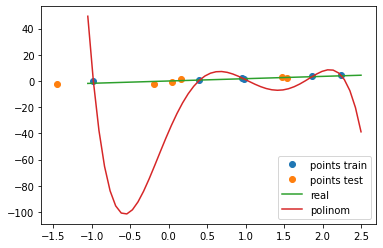

In [ ]:
plt.plot(X_tr, y_tr, 'o', label = 'points train')
plt.plot(X_ts, y_ts, 'o', label = 'points test')
plt.plot(np.linspace(x_begin, x_end), w*np.linspace(x_begin, x_end), '-', label = 'real')
plt.plot(np.linspace(x_begin, x_end), y_polinom, '-', label = 'polinom')

plt.legend(loc='best')
plt.show()

# Борьба с переобучением

Бороться с переобучениям можно многими способами:
1. Изменения структуры модели
2. Добавление регуляризаторов
3. ...

Но большинство методов борьбы с регуляризацией добавляют свои параметры (гиперпараметры), которые также нужно оптимизировать. Обычно для их оптимизации и используется метод Cross-Validation и Leave One Out.

Для нашего синтетического примера. В качестве параметра $\mu$ можно рассмоттреть степень полинома для аппроксимации (изменения структуры модели).

Пример, где реально используется LOO будет рассмотрен на следующей лекции.

# Разные задачи машинного обучения

Задачи машиного обучения можно разделить на два типа:
1. Решается одна прикладная задача. В данном случае основной целью является получить наилучший результат на отложенной выборке. В данном случае обычно есть одна выборка и нужно перебрать все возможные методы машинного обучения, чтобы получить лучший результат.
2. Тестируется метод на большом количестве реальных данных. В данном случае основной целью является протестировать новый метод на широком спектре задач. Рассматриваются задачи из разных областей.
3. Тестирования метода на большом количестве синтетических данных/ полусинтеттиических данных. Синтетические данные позволяют проверять разные гипотезы о модели.

## Задачи оптимизации

$$
\hat{w} = \arg\min_{w \in 𝑾} 𝓛\bigr(w, \textbf{X}, \textbf{y}\bigr),
$$

Варианты решения:
1. аналитическое решение
2. стохастический градиентынй спуск

In [13]:
np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

# Решение задачи регрессии - аналитический метод
w = np.linalg.inv(X.T@X)@X.T@Y

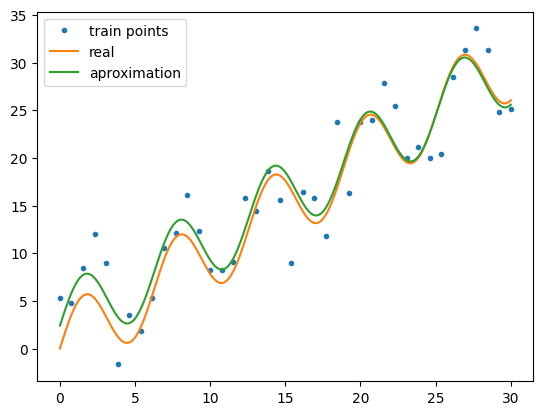

In [14]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

Задача бинарной классификации
Данная задача не решается аналитически, так как невозможно функция не дифференцируема

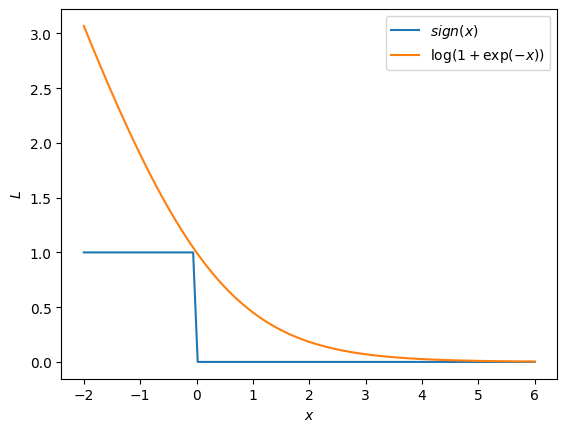

In [33]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)
def upper_bound(x):
    return np.log2(1+np.exp(-x))

x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

In [34]:
torch.manual_seed(0)

l = 1000
n = 2

X = torch.randn([l, n])
w_true = torch.randn([n])
Y = torch.ones([l])
Y[X@w_true < 0] = -1

In [28]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss_sqrt = []
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/np.sqrt(k)

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем q с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [35]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9890000224113464


In [36]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss.append(torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/k

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем g с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [37]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X, Y)
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lambda k: 1/np.sqrt(k+1))

list_of_loss_torch = []
for x, y in generator:
    optimizer.zero_grad()

    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    q = torch.log2(1+torch.exp(-y*(x@w))).mean()

    q.backward()

    optimizer.step()
    scheduler.step()

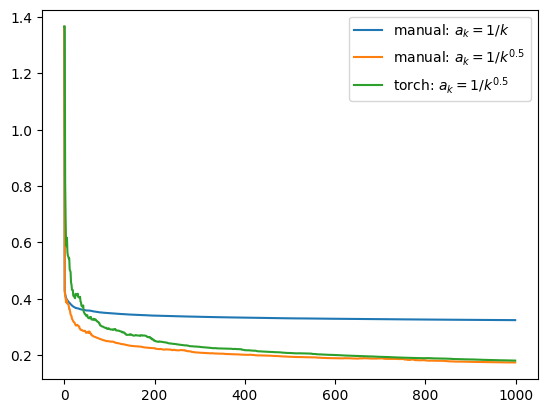

In [32]:
plt.plot(list_of_loss, label="manual: $a_k = 1/k$")
plt.plot(list_of_loss_sqrt, label="manual: $a_k = 1/k^{0.5}$")
plt.plot(list_of_loss_torch, label="torch: $a_k = 1/k^{0.5}$")
plt.legend(loc='best')
plt.show()

### LOO

Leave-one-out - метод кросс валидации даных

In [38]:
np.random.seed(0)
l = 1000
n = 2

X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [24]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

In [39]:
loo = LeaveOneOut()
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
best_gamma = sorted(gamma_scores,
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False,
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.768


In [41]:
best_gamma

1e-10

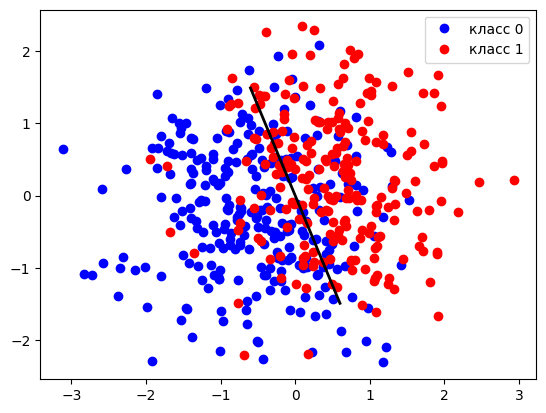

In [42]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o',
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6),
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()